# NLP : Assignment 3
### Rohit Roy | MDS202340

In [ ]:
from collections import Counter, defaultdict

from nltk import ngrams, word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from scipy.sparse import dok_matrix
from scipy.spatial.distance import cosine
from scipy.sparse.linalg import svds

import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#### 1. Building Vocabulary

I am using the Bengali corpus from the 1st assignment, which was split into 8 files each of 100000 lines.

In [ ]:
input_files = ['split/BengaliCorpus_1.txt','split/BengaliCorpus_2.txt',
               'split/BengaliCorpus_3.txt','split/BengaliCorpus_4.txt',
               'split/BengaliCorpus_5.txt','split/BengaliCorpus_6.txt',
               'split/BengaliCorpus_7.txt','split/BengaliCorpus_8.txt']

In [ ]:
# Function to generate vocab counts.

def gen_unigrams(files):
    x = Counter()   # Counter to store unigrams
    for file in files:
        with open(file, 'r',encoding="utf-8") as f:
            for line in tqdm(f.readlines()):
                for sent in sent_tokenize(line):
                    x.update([i[0] for i in ngrams(word_tokenize(sent), 1)])
    return x

In [ ]:
vocab_counts = gen_unigrams(input_files)

100%|██████████| 37824/37824 [00:15<00:00, 2479.74it/s]


In [ ]:
print("Size of vocab :",len(vocab_counts))

Size of vocab : 2755120


Now I remove the stopwords and those words whose counts are more than 100, to get a reduced vocabulary.

In [ ]:
stp = set(stopwords.words('english') + stopwords.words('bengali'))

vocab = {x for x, count in vocab_counts.items() if count >= 100 and x not in stp}

In [ ]:
print("Size of reduced vocab :", len(vocab))

Size of reduced vocab : 30779


Now I create a dictionary that will act as index of every word in the vocab, which would also contain the words as values and the numbers as keys.

In [ ]:
# Number to word
vocab_list = list(vocab)

# Corresponding word to number
vocab_pos = {vocab_list[i] : i for i in range(len(vocab_list))}

# Compiling both into a dictionary
vocab_idx = vocab_pos.copy()
vocab_idx.update({i : w for i,w in enumerate(vocab_list)})

#### 2. Building Co-occurance matrix

The function below returns a co-occurance matrix, which is a csr matrix.

In [ ]:
def co_occurances(files):
    window = 4

    # Using a ramp of window 4
    ramp = [0] + [*range(window,0,-1)]     # ramp = [0,4,3,2,1]

    occurances = defaultdict(lambda : Counter())

    for file in files:
        with open(file, 'r',encoding="utf-8") as corpus:
            for line in tqdm(corpus.readlines()):
                all_grams = ngrams(word_tokenize(line), window+1, pad_right = True, pad_left = True)
                for grams in all_grams:

                    if grams[0] in vocab :
                        for idx, gram in enumerate(grams):
                            if gram in vocab:
                                occurances[vocab_idx[grams[0]]][vocab_idx[gram]] += ramp[idx]

                    # Doing the same as above with the gram reversed
                    grams_rev = grams[::-1]

                    if grams_rev[0] in vocab:
                        for idx, gram in enumerate(grams_rev):
                            if gram in vocab:
                                occurances[vocab_idx[grams_rev[0]]][vocab_idx[gram]] += ramp[idx]

    # Initializing a 0 matrix
    mat = dok_matrix((len(vocab), len(vocab)), dtype=np.int64)

    # Filling the matrix
    for i in tqdm(range(len(vocab))):
        for j in occurances[i].keys():
            mat[i,j] = occurances[i][j]

    # Converting to csr matrix
    return mat.tocsr()

In [ ]:
cocrmat = co_occurances(input_files)

100%|██████████| 30779/30779 [05:30<00:00, 93.20it/s] 


#### 3. Building Word-embedding matrix

We iterate through the non-zero entries of the co-occurance matrix and calculate the correlation as per the formula given in the COALS paper. We don't care about the 0 entries since it is going to give us negative correlation anyway.

In [ ]:
def word_embedding(matrix):

    # Storing total, row and column sums.
    mat_tot = matrix.sum()
    row_sums = matrix.sum(axis = 1).flatten()
    col_sums = matrix.sum(axis = 0).flatten()

    mat = dok_matrix((len(vocab), len(vocab)), dtype=np.float64)

    # List of non-zero indices
    indices = list(zip(*matrix.nonzero()))

    for a,b in tqdm(indices):
        sum_aj = row_sums[0,a]
        sum_jb = col_sums[0,b]
        num = mat_tot * matrix[a,b] - sum_aj * sum_jb
        l1den = np.multiply(sum_aj,(mat_tot - sum_aj), dtype=np.float64)
        l2den = np.multiply(sum_jb,(mat_tot - sum_jb), dtype=np.float64)
        den = np.multiply(l1den,l2den,dtype=np.float64)     # Using np.multiply so that the value stays in limit
        val = num / math.sqrt(float(den))
        if val > 0:
            mat[a,b] = math.sqrt(val)

    return mat.tocsr()

embmat = word_embedding(cocrmat)


100%|██████████| 37017438/37017438 [25:53<00:00, 23823.59it/s] 


#### 4. Finding Similar Words

We find the k closest words to the selected word using the closest_words function which also returns the cosine distance between them.

In [ ]:
def closest_words(x, k=5):
    a1 = embmat[vocab_idx[x],:].toarray().flatten()

    dists = [(i, cosine(a1, embmat[vocab_idx[i],:].toarray().flatten())) for i in tqdm(vocab)]

    dists.sort(key= lambda x:x[1])

    return dists[1:(k+1)]

In [ ]:
# An example

closest_words('বাবা')

100%|██████████| 30779/30779 [00:05<00:00, 5907.46it/s]


[('পিতা', 0.44295707035580256),
 ('মা', 0.4854277357770067),
 ('ভাই', 0.5082915026168331),
 ('বাবার', 0.5321733100172309),
 ('পুত্র', 0.5682259785339041)]

Selecting 5 nouns :

In [ ]:
nouns = ['বাবা', 'শর্ত', 'নিয়ম', 'শনিবার', 'রোহিত']

Calculating the list of similar words and their cosine distances for each noun :

In [ ]:
similar = []
for w in nouns:
    similar.append([(w,0)]+[(x,round(dist,2)) for x,dist in closest_words(w, k=5)])

100%|██████████| 30779/30779 [00:05<00:00, 6151.91it/s]


Printing the similar words :

In [ ]:
print("Top 5 similar words : \n")

for words in similar:
    print(f"{words[0][0]} : {words[1]}, {words[2]}, {words[3]}, {words[4]}, {words[5]}")

Top 5 similar words : 

বাবা : ('পিতা', 0.44), ('মা', 0.49), ('ভাই', 0.51), ('বাবার', 0.53), ('পুত্র', 0.57)
শর্ত : ('শর্তাবলী', 0.71), ('নিয়ম', 0.73), ('প্রতিশ্রুতি', 0.73), ('অনুমতি', 0.74), ('নীতি', 0.75)
নিয়ম : ('নীতি', 0.66), ('নিয়মের', 0.66), ('বিধি', 0.67), ('মেনে', 0.71), ('ভিত্তি', 0.71)
শনিবার : ('বৃহস্পতিবার', 0.47), ('সোমবার', 0.48), ('শুক্রবার', 0.48), ('মঙ্গলবার', 0.48), ('বুধবার', 0.49)
রোহিত : ('শর্মা', 0.74), ('শিল্পা', 0.74), ('সুনীল', 0.76), ('রাহুল', 0.78), ('সঞ্জয়', 0.78)


#### 5. Visualization of the similar words

From the list of closest words, we choose the word 'বাবা' for visualization since it looks like it has a good set of similar words.

I give 2 different ways of visualization, one is with the word vector of the original word embedding matrix after normalization of the 1st 200 elements and the other is decomposing the matrix via SVD to a 200 column matrix and then using the same steps. It is giving better results with the SVD decomposed matrix as shown.

In [ ]:
def svd_reduce(matrix, num_components):

    U, S, VT = svds(matrix, k = num_components)

    return U

reduced_wordvec = svd_reduce(embmat, 200)

This reduced_wordvec can be also considered as the word embedding matrix, with dense word vectors, so that the dimensionality is reduced to 200.

Using the original matrix :

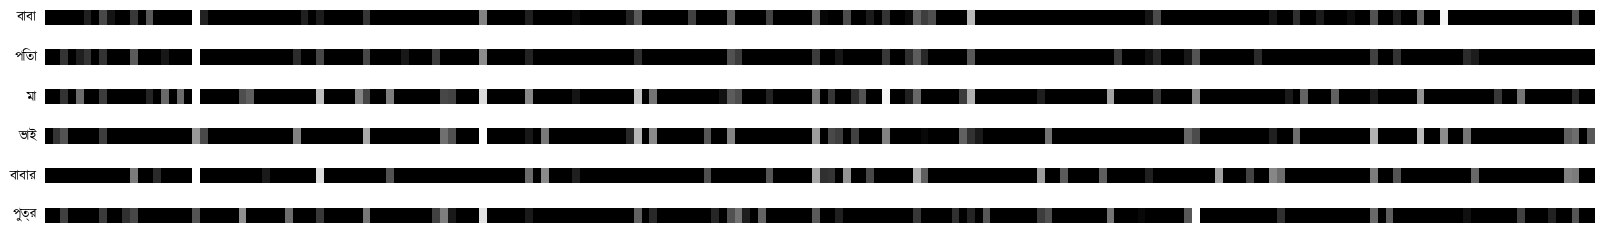

In [ ]:
# similar[0] is the word list we want.

vector_list = []

for word,_ in similar[0]:
    vector = embmat[vocab_idx[word],:200].toarray().flatten()
    # Normalizing here
    vector = (vector - np.min(vector)) / (np.max(vector) - np.min(vector)) * 255
    vector_list.append(vector)

# print(vector_list)

fig, ax = plt.subplots(6,1, figsize = (20,3))
prop = fm.FontProperties(fname = 'kalpurush.ttf')

for i in range(6):
    vector_data = vector_list[i].reshape(1, -1)
    ax[i].imshow(vector_data, cmap='gray', extent=[0, 200, -1, 1])
    ax[i].text(-1, 0.1, f"{similar[0][i][0]}", va='center', ha='right', fontproperties=prop)
    ax[i].axis('off')

plt.show()

Using the SVD decomposed matrix :

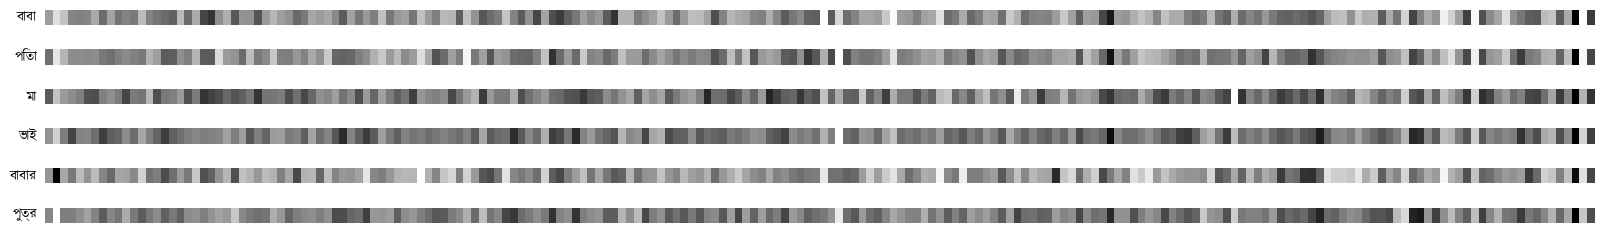

In [ ]:
vector_list = []

for word,_ in similar[0]:
    vector = reduced_wordvec[vocab_idx[word]]
    # Normalizing here
    vector = (vector - np.min(vector)) / (np.max(vector) - np.min(vector)) * 255
    vector_list.append(vector)

fig, ax = plt.subplots(6,1, figsize = (20,3))

for i in range(6):
    vector_data = vector_list[i].reshape(1, -1)
    ax[i].imshow(vector_data, cmap='gray', extent=[0, 200, -1, 1])
    ax[i].text(-1, 0.1, f"{similar[0][i][0]}", va='center', ha='right', fontproperties=prop)
    ax[i].axis('off')

plt.show()